Цель задания: изучить работу с готовыми моделями из torchvision.

Контекст
Вам необходимо подобрать базовую модель для работы по вашей задаче. Вы пробуете обучать различные модели на “ваших” данных. По результатам отберёте лучшую для дальнейшего обучения.

Задание
Вам необходимо провести эксперименты по начальному обучению различных моделей и сравнить результаты.

Возьмите датасет EMNIST из torchvision
Обучите на нём модели: ResNet 18, VGG 16, Inception v3, DenseNet 161 (с нуля по 10 эпох)
Сведите результаты обучения моделей (графики лоса) в таблицу и сравните их.
Задание со звездочкой*
Выполните то же задание, используя датасет hymenoptera_data

Инструкция к выполнению задания

Загрузите датасет, посмотрите примеры картинок в нём и проверьте наличествующие классы и их дисбаланс.
Создайте модель текущего типа, используя интерфейс torchvision для нужного количества классов.
Обучите модель с нуля 10 эпох. Фиксируйте значение функции потерь в список для последующего отображения.
Повторите пункты 2 и 3 для всех указанных вариантов моделей.
Формат сдачи работы
Прикрепите ссылку на готовое решение в личном кабинете. Работу можно отправлять в виде ссылки на python-ноутбук из GitHub, Google Colaboratory или аналогичных платформ. Не забудьте открыть доступ на просмотр и комментирование.

Критерии оценивания
По итогу выполнения задания вы получите зачёт.

Задание считается выполненным, если:

вы обучили каждую модель до некоторого улучшения качества
составлена таблица обучения для сравнения
Задание будет отправлено на доработку, если:

использованы не все типы моделей
не составлена сводная таблица с результатами

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
from torch import nn
import torch.utils.data as data_utils
import torchvision as tv
from torchsummary import summary
import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline


Функции, которые помогут отслеживать память и сохранять промежуточные значения, чтобы не допустить превышения лимитов.

In [3]:
import inspect
import pickle
import os
import sys
base_dir = '/content/drive/MyDrive/tmp/'
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

def show_memory_usage(objs=locals().items()):
    for name, size in sorted(((name, sys.getsizeof(value)) for name, value in objs), key=lambda x: -x[1])[:10]:
        if name[0] != '_' and name not in ['rcParams', 'rcParamsDefault', 'rcParamsOrig', 'sctypeNA']:
            print(f"{name:>30}: {sizeof_fmt(size):>8}")

def save_pickle(obj, fname, dir=base_dir):
    full_fname = dir + '/' + fname
    with open(full_fname, 'wb') as pickle_file:
        pickle.dump(obj, pickle_file)
    print(f"saved \"{fname}\" ({sizeof_fmt(os.path.getsize(full_fname))}).")

def load_pickle(fname, dir=base_dir):
    full_fname = dir + '/' + fname
    with open(full_fname, 'rb') as pickle_file:
        obj = pickle.load(pickle_file)
    print(f"loaded \"{fname}\" ({sizeof_fmt(os.path.getsize(full_fname))}).")
    return obj

In [4]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0, 0
    net.eval()
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [5]:
def train_inception(net_name, net, train_iter, test_iter, trainer, num_epochs):
    Loss_train_list = []
    Accuracy_train_list = []
    Accuracy_test_list = []

    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum') # используем категорийную кроссэнтропию и суммируем ошибки - чтобы сильнее их выделить
    net.train() # переключаем сеть в режим обучения
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()

        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            net.train() # снова переключаем в режим обучения, т.к. после перевода в режим исполнения и подсчета аккураси, дополнительный вектор перестает выдаваться
            #y_hat = net(X)
            y_hat, aux_outputs = net(X)
            loss1 = loss(y_hat, y)
            loss2 = loss(aux_outputs, y)
            l = loss1 + 0.4*loss2
            #l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 10 == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. "
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")
        test_acc = evaluate_accuracy(test_iter, net.to(device)) # считаем аккураси на тестовых данных
        print('-' * 20)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')

        Loss_train_list.append(train_l_sum / n)
        Accuracy_train_list.append(train_acc_sum / n)
        Accuracy_test_list.append(test_acc)

    x1 = range(0, num_epochs)
    x2 = range(0, num_epochs)
    x3 = range(0, num_epochs)
    y1 = Loss_train_list
    y2 = Accuracy_train_list
    y3 = Accuracy_test_list
    #print(f'')
    fig, ax = plt.subplots(3,1)
    fig.set_figwidth(6)
    fig.set_figheight(12)
    fig.suptitle('loss & accuracy')
    ax[0].plot(x1, y1, 'o-')
    ax[0].set_xlabel('train loss vs. epoches')
    ax[0].set_ylabel('train loss')
    ax[1].plot(x2, y2, '.-')
    ax[1].set_xlabel('train accuracy vs. epoches')
    ax[1].set_ylabel('train accuracy')
    ax[2].plot(x3, y3, '.-')
    ax[2].set_xlabel('test accuracy vs. epoches')
    ax[2].set_ylabel('test accuracy')
    plt.show()
    path_png = "/content/drive/MyDrive/tmp/" + net_name + ".png"
    fig.savefig(path_png, format='png')

    save_pickle(Loss_train_list,net_name + '_' + 'Loss_train_list' + '.pickle',base_dir)
    save_pickle(Accuracy_train_list,net_name + '_' + 'Accuracy_train_list' + '.pickle',base_dir)
    save_pickle(Accuracy_test_list,net_name + '_' + 'Accuracy_test_list' + '.pickle',base_dir)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## DataSet

EMNIST ByClass: 697 932 characters. 62 unbalanced classes.

EMNIST ByMerge: 697 932 characters. 47 unbalanced classes.

EMNIST Balanced: 112 800 characters. 47 balanced classes.

EMNIST Letters: 124 800 characters. 26 balanced classes.

EMNIST Digits: 240 000 characters. 10 balanced classes.

EMNIST MNIST: 60 000 characters. 10 balanced classes.

<font color=green size=3>
Видим, что полных набора 3.
<br>
Из них:
<br>
<br>
EMNIST Balanced - специально сбалансированный, для облегчения обучения.
<br>
EMNIST ByClass - самый полный  и несбалансированный.
<br>
Будем использовать и тот и другой, чтобы посмотреть на разницу для обучения.
<br>
</font>

In [7]:
BATCH_SIZE = 256
indices = torch.arange(112800)
#indices = torch.arange(512)

transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3), # предобученные модели работают с 3х канальными рисунками, поэтому искусственно делаем из одного три канала
    tv.transforms.Resize((299,299)), # трансформируем наши изображения до требуемого размера
    tv.transforms.ToTensor()
])
train_dataset_bc = tv.datasets.EMNIST(root="./data", split='byclass', train=True, transform=transoforms, download=True)
test_dataset_bc = tv.datasets.EMNIST(root="./data", split='byclass', train=False, transform=transoforms, download=True)

train_dataset_bc_min = data_utils.Subset(train_dataset_bc, indices)
test_dataset_bc_min = data_utils.Subset(test_dataset_bc, indices)
train_iter_bc = torch.utils.data.DataLoader(train_dataset_bc_min, batch_size=BATCH_SIZE)
test_iter_bc = torch.utils.data.DataLoader(test_dataset_bc_min, batch_size=BATCH_SIZE)
# уменьшаем выборку данных, чтобы протестировать код на cpu быстрее

#train_iter_bc = torch.utils.data.DataLoader(train_dataset_bc, batch_size=BATCH_SIZE)
#test_iter_bc = torch.utils.data.DataLoader(test_dataset_bc, batch_size=BATCH_SIZE)

#############################################3

train_dataset_bl = tv.datasets.EMNIST(root="./data", split='balanced', train=True, transform=transoforms, download=True)
test_dataset_bl = tv.datasets.EMNIST(root="./data", split='balanced', train=False, transform=transoforms, download=True)

#train_dataset_bl_min = data_utils.Subset(train_dataset_bl, indices)
#test_dataset_bl_min = data_utils.Subset(test_dataset_bl, indices)
#train_iter_bl = torch.utils.data.DataLoader(train_dataset_bl_min, batch_size=BATCH_SIZE)
#test_iter_bl = torch.utils.data.DataLoader(test_dataset_bl_min, batch_size=BATCH_SIZE)
# уменьшаем выборку данных, чтобы протестировать код на cpu быстрее


train_iter_bl = torch.utils.data.DataLoader(train_dataset_bl, batch_size=BATCH_SIZE)
test_iter_bl = torch.utils.data.DataLoader(test_dataset_bl, batch_size=BATCH_SIZE)

100%|██████████| 561753746/561753746 [00:10<00:00, 55149537.38it/s]


Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw


<font color=green size=3>
Inception v3 feature extraction  
<br>
EMNIST ByClass
<br>
</font>

In [ ]:
model_name = 'model_inception_v3_bc'
model_inception_v3_bc = tv.models.inception_v3(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model_inception_v3_bc = model_inception_v3_bc.to(device)

In [ ]:
print(model_inception_v3_bc)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
summary(model_inception_v3_bc.to(device), input_size=(3, 299, 299)) # проверяем размерности архитектуры

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

In [ ]:
# Убираем требование градиента:
for param in model_inception_v3_bc.parameters():
    param.requires_grad = False # Замораживаем веса. Мы их менять не будем.

In [ ]:
#model_inception_v3_bc.fc = nn.Linear(in_features=2048, out_features=62, bias=True).to(device)
# Parameters of newly constructed modules have requires_grad=True by default
# Handle the auxilary net
num_ftrs = model_inception_v3_bc.AuxLogits.fc.in_features
model_inception_v3_bc.AuxLogits.fc = nn.Linear(num_ftrs, 62)
# Handle the primary net
num_ftrs = model_inception_v3_bc.fc.in_features
model_inception_v3_bc.fc = nn.Linear(num_ftrs, 62)

In [ ]:
print("Params to learn:") # выпишем в список, какие параметры будут дообучаться (изменяться под новую задачу)
params_to_update = []
for name, param in model_inception_v3_bc.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 AuxLogits.fc.weight
	 AuxLogits.fc.bias
	 fc.weight
	 fc.bias


In [ ]:
summary(model_inception_v3_bc.to(device), input_size=(3, 299, 299)) # проверяем размерности архитектуры

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

Step 0. time since epoch: 2.489. Train acc: 0.008. Train Loss: 5.896
Step 10. time since epoch: 21.502. Train acc: 0.030. Train Loss: 5.678
Step 20. time since epoch: 39.192. Train acc: 0.044. Train Loss: 5.498
Step 30. time since epoch: 56.821. Train acc: 0.050. Train Loss: 5.392
Step 40. time since epoch: 74.163. Train acc: 0.059. Train Loss: 5.314
Step 50. time since epoch: 91.776. Train acc: 0.067. Train Loss: 5.257
Step 60. time since epoch: 109.808. Train acc: 0.073. Train Loss: 5.201
Step 70. time since epoch: 127.551. Train acc: 0.084. Train Loss: 5.147
Step 80. time since epoch: 145.024. Train acc: 0.094. Train Loss: 5.098
Step 90. time since epoch: 162.400. Train acc: 0.106. Train Loss: 5.051
Step 100. time since epoch: 179.812. Train acc: 0.116. Train Loss: 5.012
Step 110. time since epoch: 197.281. Train acc: 0.126. Train Loss: 4.975
Step 120. time since epoch: 214.883. Train acc: 0.135. Train Loss: 4.938
Step 130. time since epoch: 232.336. Train acc: 0.145. Train Loss: 4.

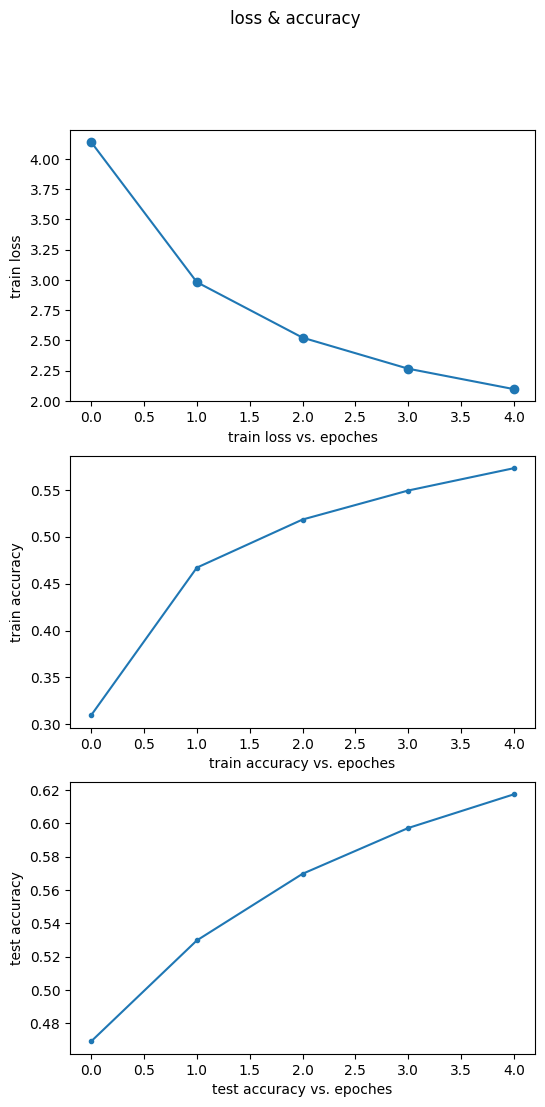

saved "model_inception_v3_bc_Loss_train_list.pickle" (61.0 B).
saved "model_inception_v3_bc_Accuracy_train_list.pickle" (61.0 B).
saved "model_inception_v3_bc_Accuracy_test_list.pickle" (61.0 B).
CPU times: user 1h 30min 49s, sys: 10min 39s, total: 1h 41min 29s
Wall time: 1h 42min 2s


In [ ]:
%%time
lr, num_epochs = 0.0001, 5
trainer = torch.optim.Adam(params_to_update, lr=lr)
train_inception(model_name, model_inception_v3_bc, train_iter_bc, test_iter_bc, trainer, num_epochs)

In [ ]:
model_inception_v3_bc.aux_logits

True

In [ ]:
path_model = base_dir + model_name + '.pt'
torch.save(model_inception_v3_bc.state_dict(), path_model)

In [ ]:
torch.cuda.empty_cache()

<font color=green size=3>
Inception v3 feature extraction  
<br>
EMNIST Balanced
<br>
</font>

In [8]:
model_name = 'model_inception_v3_bl'
model_inception_v3_bl = tv.models.inception_v3(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 55.6MB/s] 


In [9]:
model_inception_v3_bl = model_inception_v3_bl.to(device)

In [10]:
print(model_inception_v3_bl)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [11]:
summary(model_inception_v3_bl.to(device), input_size=(3, 299, 299)) # проверяем размерности архитектуры

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

In [12]:
# Убираем требование градиента:
for param in model_inception_v3_bl.parameters():
    param.requires_grad = False # Замораживаем веса. Мы их менять не будем.

In [13]:
#model_inception_v3_bc.fl = nn.Linear(in_features=2048, out_features=62, bias=True).to(device)
# Parameters of newly constructed modules have requires_grad=True by default
# Handle the auxilary net
num_ftrs = model_inception_v3_bl.AuxLogits.fc.in_features
model_inception_v3_bl.AuxLogits.fc = nn.Linear(num_ftrs, 62)
# Handle the primary net
num_ftrs = model_inception_v3_bl.fc.in_features
model_inception_v3_bl.fc = nn.Linear(num_ftrs, 62)

In [14]:
print("Params to learn:") # выпишем в список, какие параметры будут дообучаться (изменяться под новую задачу)
params_to_update = []
for name, param in model_inception_v3_bl.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 AuxLogits.fc.weight
	 AuxLogits.fc.bias
	 fc.weight
	 fc.bias


Step 0. time since epoch: 1.738. Train acc: 0.020. Train Loss: 5.849
Step 10. time since epoch: 18.448. Train acc: 0.028. Train Loss: 5.726
Step 20. time since epoch: 35.094. Train acc: 0.027. Train Loss: 5.632
Step 30. time since epoch: 51.993. Train acc: 0.032. Train Loss: 5.557
Step 40. time since epoch: 68.857. Train acc: 0.037. Train Loss: 5.494
Step 50. time since epoch: 85.879. Train acc: 0.043. Train Loss: 5.441
Step 60. time since epoch: 102.979. Train acc: 0.048. Train Loss: 5.392
Step 70. time since epoch: 120.415. Train acc: 0.053. Train Loss: 5.348
Step 80. time since epoch: 138.014. Train acc: 0.060. Train Loss: 5.307
Step 90. time since epoch: 155.544. Train acc: 0.066. Train Loss: 5.267
Step 100. time since epoch: 172.794. Train acc: 0.073. Train Loss: 5.230
Step 110. time since epoch: 190.006. Train acc: 0.081. Train Loss: 5.193
Step 120. time since epoch: 207.350. Train acc: 0.088. Train Loss: 5.158
Step 130. time since epoch: 224.578. Train acc: 0.095. Train Loss: 5.

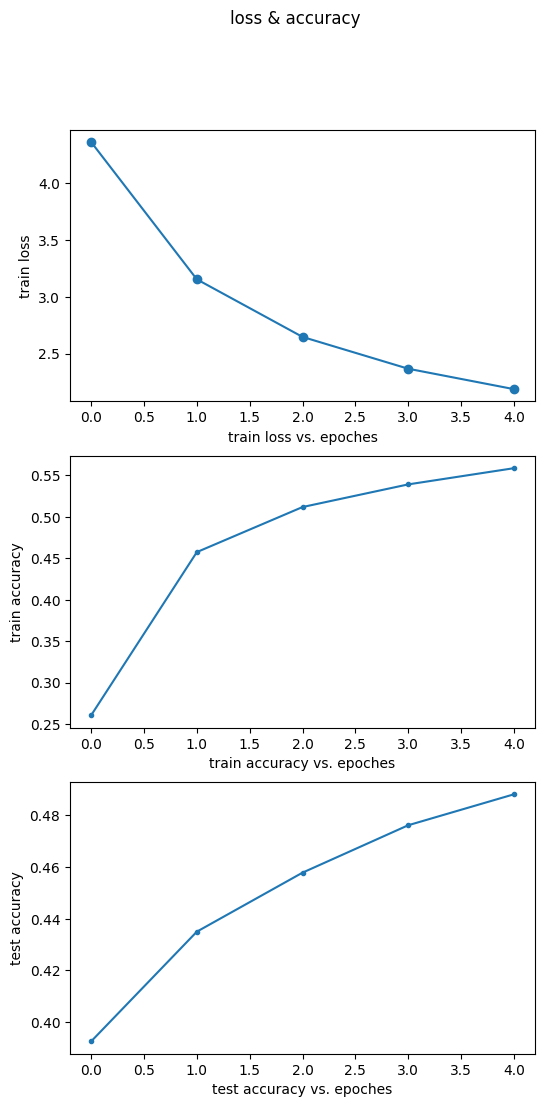

saved "model_inception_v3_bl_Loss_train_list.pickle" (61.0 B).
saved "model_inception_v3_bl_Accuracy_train_list.pickle" (61.0 B).
saved "model_inception_v3_bl_Accuracy_test_list.pickle" (61.0 B).
CPU times: user 1h 29min 17s, sys: 10min 54s, total: 1h 40min 11s
Wall time: 1h 40min 37s


In [15]:
%%time
lr, num_epochs = 0.0001, 5
trainer = torch.optim.Adam(params_to_update, lr=lr)
train_inception(model_name, model_inception_v3_bl, train_iter_bl, test_iter_bc, trainer, num_epochs)

In [16]:
path_model = base_dir + model_name + '.pt'
torch.save(model_inception_v3_bl.state_dict(), path_model)

In [ ]:
torch.cuda.empty_cache()

<font color=green size=3>
Это шаблон примечания
<br>
<br>
</font>